<a href="https://colab.research.google.com/github/Farah-Saleem91/Car-Insurance-Data/blob/main/car_insurance_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.What is the target? (You are required to complete a classification task for this project)

**our targest is Outcome**

2.What does one row represent? (A person? A business? An event? A product?)

**person**

3.How many features does the data have?

**19**

4.How many rows are in the dataset?

**10,000**

5.What opportunities exist for dimensionality reduction or feature selection with this dataset?
**I believe there is no need from reducing the number of features because we dont have a lot of features, and we have a good records of 10000**

6.What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor # Import RandomForestRegressor
# Set pandas as the default output for sklearn
from sklearn import set_config
from sklearn.linear_model import LinearRegression
set_config(transform_output='pandas')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [ ]:
fpath='/content/drive/MyDrive/Car_Insurance_Claim.csv'

df = pd.read_csv(fpath)
df=df.set_index('ID')

df.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 569520 to 442696
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  10000 non-null  object 
 1   GENDER               10000 non-null  object 
 2   RACE                 10000 non-null  object 
 3   DRIVING_EXPERIENCE   10000 non-null  object 
 4   EDUCATION            10000 non-null  object 
 5   INCOME               10000 non-null  object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    10000 non-null  float64
 8   VEHICLE_YEAR         10000 non-null  object 
 9   MARRIED              10000 non-null  float64
 10  CHILDREN             10000 non-null  float64
 11  POSTAL_CODE          10000 non-null  int64  
 12  ANNUAL_MILEAGE       9043 non-null   float64
 13  VEHICLE_TYPE         10000 non-null  object 
 14  SPEEDING_VIOLATIONS  10000 non-null  int64  
 15  DUIS                 10000 non-null

#EDA functions

In [ ]:
"""UNIVARIATE PLOTTING FUNCTIONS FOR EDA"""
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


# TO DO: add the new print statements from explore_categorical
def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


In [ ]:
df['AGE'].value_counts()

,count
AGE,
26-39,3063
40-64,2931
16-25,2016
65+,1990


In [ ]:

# define a function that returns 'young' or 'youth' or young youth or old
def bin_age(AGE):
    if AGE == '16-25':
        return 'Young'
    elif AGE == '26-39':
        return 'early youth'
    elif AGE == '40-64':
        return 'youth'
    else:
        return 'old'

In [ ]:
# apply bin_age() function to each item in the 'AGE' column
df['AGE'] = df['AGE'].apply(bin_age)


In [ ]:
df['AGE'].value_counts()

,count
AGE,
early youth,3063
youth,2931
Young,2016
old,1990


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


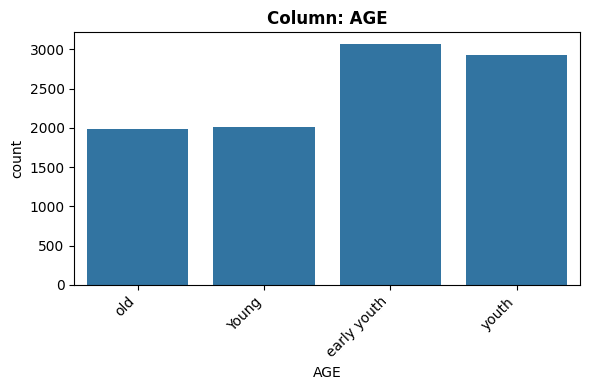

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'early youth' occurs 3063 times (30.63%)
- Not constant or quasi-constant.


In [ ]:
feature='AGE'
explore_categorical(df,feature);

In [ ]:
df['GENDER'].value_counts()

,count
GENDER,
female,5010
male,4990


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


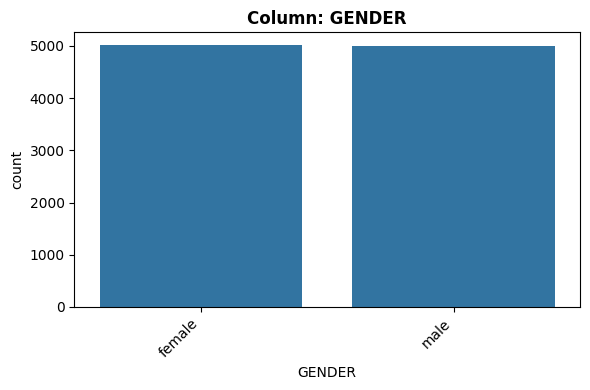

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'female' occurs 5010 times (50.1%)
- Not constant or quasi-constant.


In [ ]:
feature='GENDER'
explore_categorical(df,feature);

In [ ]:
df['RACE'].value_counts()

,count
RACE,
majority,9012
minority,988


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


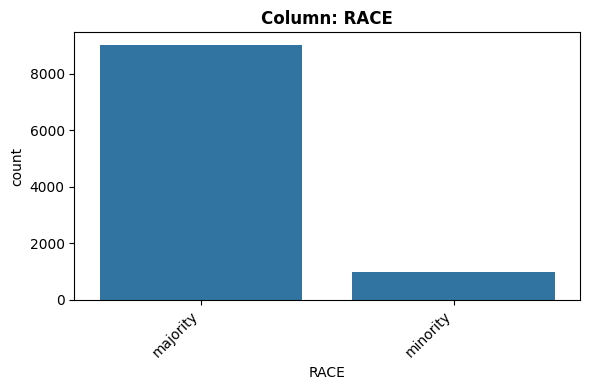

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'majority' occurs 9012 times (90.12%)
- Not constant or quasi-constant.


In [ ]:
feature='RACE'
explore_categorical(df,feature);

In [ ]:
df['DRIVING_EXPERIENCE'].value_counts()

,count
DRIVING_EXPERIENCE,
0-9y,3530
10-19y,3299
20-29y,2119
30y+,1052


In [ ]:
# Define a function to bin DRIVING_EXPERIENCE
def bin_driving_experience(experience):
    if experience == '0-9y':
        return 'Beginner'
    elif experience == '10-19y':
        return 'Experienced'
    elif experience == '20-29y':
        return 'Advanced'
    else:
        return 'Expert'

In [ ]:
# Apply the bin_driving_experience function to the 'DRIVING_EXPERIENCE' column
df['DRIVING_EXPERIENCE'] = df['DRIVING_EXPERIENCE'].apply(bin_driving_experience)

In [ ]:
df['DRIVING_EXPERIENCE'].value_counts()

,count
DRIVING_EXPERIENCE,
Beginner,3530
Experienced,3299
Advanced,2119
Expert,1052


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


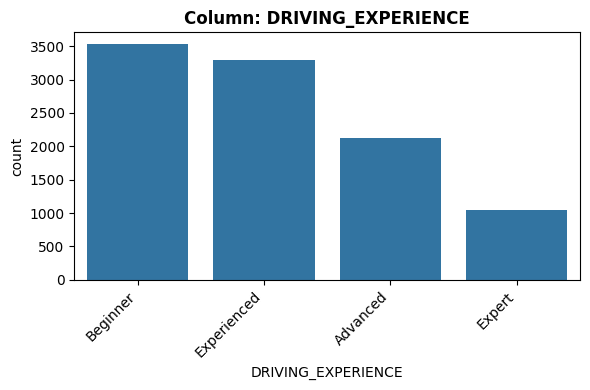

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Beginner' occurs 3530 times (35.3%)
- Not constant or quasi-constant.


In [ ]:
feature='DRIVING_EXPERIENCE'
explore_categorical(df,feature);

In [ ]:
df['EDUCATION'].value_counts()

,count
EDUCATION,
high school,4157
university,3928
none,1915


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


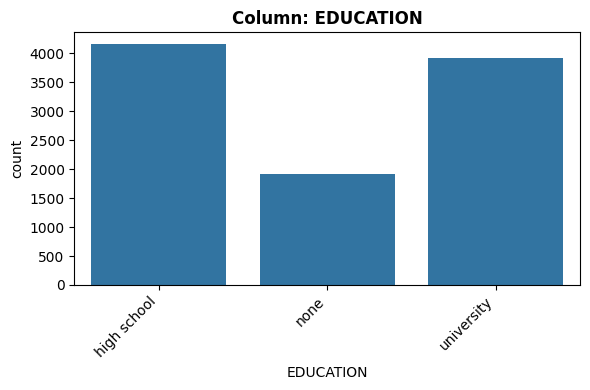

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'high school' occurs 4157 times (41.57%)
- Not constant or quasi-constant.


In [ ]:
feature='EDUCATION'
explore_categorical(df,feature);

In [ ]:
df['INCOME'].value_counts()

,count
INCOME,
upper class,4336
middle class,2138
poverty,1814
working class,1712


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


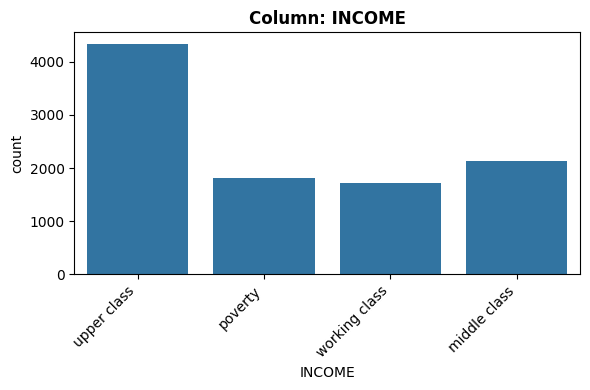

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'upper class' occurs 4336 times (43.36%)
- Not constant or quasi-constant.


In [ ]:
feature='INCOME'
explore_categorical(df,feature);

In [ ]:
df['VEHICLE_TYPE'].value_counts()

,count
VEHICLE_TYPE,
sedan,9523
sports car,477


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


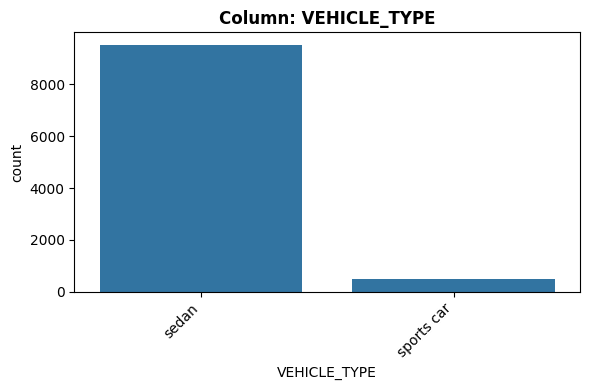

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'sedan' occurs 9523 times (95.23%)
- Not constant or quasi-constant.


In [ ]:
feature='VEHICLE_TYPE'
explore_categorical(df,feature);

In [ ]:
df['VEHICLE_YEAR'].value_counts()

,count
VEHICLE_YEAR,
before 2015,6967
after 2015,3033


/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


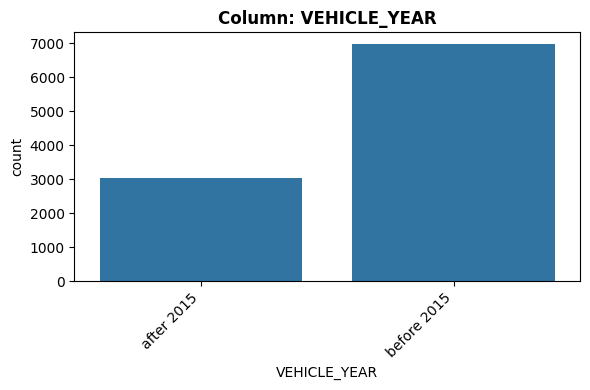

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'before 2015' occurs 6967 times (69.67%)
- Not constant or quasi-constant.


In [ ]:
feature='VEHICLE_YEAR'
explore_categorical(df,feature);

In [ ]:
df['VEHICLE_YEAR'].value_counts()

,count
VEHICLE_YEAR,
before 2015,6967
after 2015,3033


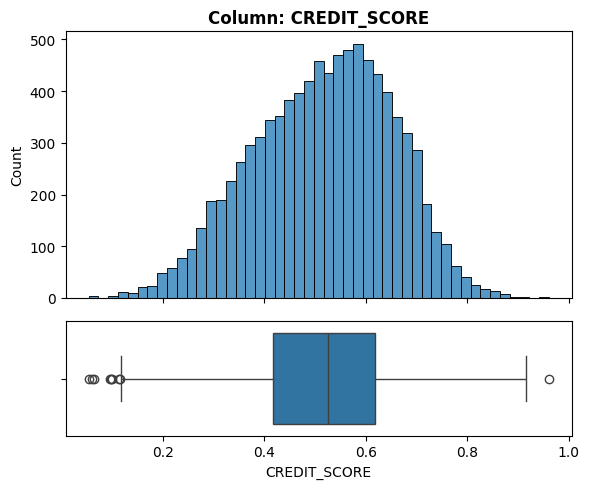

- NaN's Found: 982 (9.82%)
- Unique Values: 9018
- Most common value: 'nan' occurs 982 times (9.82%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: CREDIT_SCORE'}, xlabel='CREDIT_SCORE', ylabel='Count'>,
        <Axes: xlabel='CREDIT_SCORE'>], dtype=object))

In [ ]:
feature='CREDIT_SCORE'
explore_numeric(df, feature, figsize=(6,5))

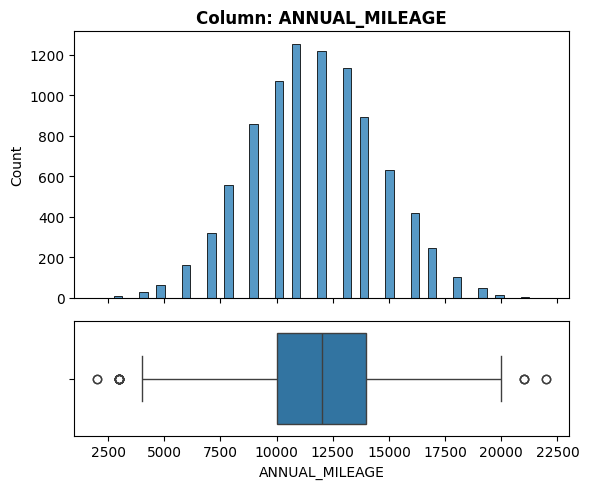

- NaN's Found: 957 (9.57%)
- Unique Values: 21
- Most common value: '11000.0' occurs 1253 times (12.53%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: ANNUAL_MILEAGE'}, xlabel='ANNUAL_MILEAGE', ylabel='Count'>,
        <Axes: xlabel='ANNUAL_MILEAGE'>], dtype=object))

In [ ]:
feature='ANNUAL_MILEAGE'

explore_numeric(df, feature, figsize=(6,5))

- Choose a model
- Preprocess data
- Fit and evaluate a default model
- Extract and visualize the top 10 features using permutation importance (from Intro to ML Week 4)
- Add your observations in a Markdown: Do these features make sense based on the business case?

#PreProcessing for ML

In [ ]:
y = df['OUTCOME']
X = df.drop(columns='OUTCOME')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
ID,,,,,,,,,,,,,,,,,
597605,youth,male,majority,Beginner,high school,upper class,0.694461,1.0,before 2015,1.0,1.0,92101,NaN,sedan,0,0,0
208394,Young,female,majority,Beginner,none,poverty,0.295794,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,0,0,0
318837,youth,male,majority,Experienced,university,upper class,NaN,1.0,before 2015,1.0,1.0,10238,NaN,sedan,0,0,3
559214,early youth,female,majority,Experienced,university,working class,0.454836,1.0,before 2015,0.0,0.0,10238,20000.0,sedan,2,0,0
555274,Young,female,majority,Beginner,none,poverty,0.152972,1.0,before 2015,1.0,0.0,10238,10000.0,sedan,0,0,0


In [ ]:
# i decided to impute by median because median is not influenced by extreme values.
num_cols = X_train.select_dtypes('number').columns

num_imputer = SimpleImputer(strategy='median')

num_scaler = StandardScaler()

num_pipe = make_pipeline(num_imputer, num_scaler)
num_tuple = ('numaric', num_pipe, num_cols)
num_tuple


('numaric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
        'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
        'PAST_ACCIDENTS'],
       dtype='object'))

In [ ]:
ord_cols = ['AGE','INCOME','EDUCATION','DRIVING_EXPERIENCE']
print("Ordinal Columns:", ord_cols)
# Create imputer for ordinal data
ord_imputer = SimpleImputer(strategy='most_frequent')
order1 = ['Young', 'early youth', 'youth', 'old']
order2= ['poverty','working class','middle class','upper class']
order3 =['none','high school','university']
order4=['Beginner','Experienced','Advanced','Expert']

ordinal_category_orders = [order1, order2, order3, order4]

ord_encoder = OrdinalEncoder (categories=ordinal_category_orders)
## Making an ord_pipe
ord_pipe = make_pipeline(ord_imputer, ord_encoder)
ord_pipe
# Making an ordinal_tuple for ColumnTransformer
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

Ordinal Columns: ['AGE', 'INCOME', 'EDUCATION', 'DRIVING_EXPERIENCE']


('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Young', 'early youth', 'youth',
                                              'old'],
                                             ['poverty', 'working class',
                                              'middle class', 'upper class'],
                                             ['none', 'high school',
                                              'university'],
                                             ['Beginner', 'Experienced',
                                              'Advanced', 'Expert']]))]),
 ['AGE', 'INCOME', 'EDUCATION', 'DRIVING_EXPERIENCE'])

In [ ]:
# Define a function to bin DRIVING_EXPERIENCE
def bin_driving_experience(experience):
    if experience == '0-9y':
        return 'Beginner'
    elif experience == '10-19y':
        return 'Experienced'
    elif experience == '20-29y':
        return 'Advanced'
    else:
        return 'Expert'

In [ ]:
# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA
# Save list of column names
ohe_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='most_frequent')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

OneHotEncoder Columns: Index(['GENDER', 'RACE', 'VEHICLE_YEAR', 'VEHICLE_TYPE'], dtype='object')


('categorical',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['GENDER', 'RACE', 'VEHICLE_YEAR', 'VEHICLE_TYPE'], dtype='object'))

In [ ]:
#Creat prerocessor
preprocessor = ColumnTransformer(transformers=[num_tuple, ord_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numaric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',...
                                                                              'Experienced',
                                                                              'Advanced',
                                                                              'Expert']]))]),
                                 ['AGE', 'INCOME', 'EDUCATION',
                                  'DRIVING_EXPERIENCE']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['GENDER', 'RACE', 'VEHICLE_YEAR', 'VEHICLE_TYPE'], dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RandomF_defult = RandomForestClassifier(random_state=42)
RandomF_defult_pipe = make_pipeline(preprocessor, RandomF_defult)
RandomF_defult_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numaric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')),
                                                 ('ordin...
                                                   'DRIVING_EXPERIENCE']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['GENDER', 'RACE', 'VEHICLE_YEAR', 'VEHICLE_TYPE'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [ ]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

In [ ]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5144
         1.0       1.00      1.00      1.00      2356

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



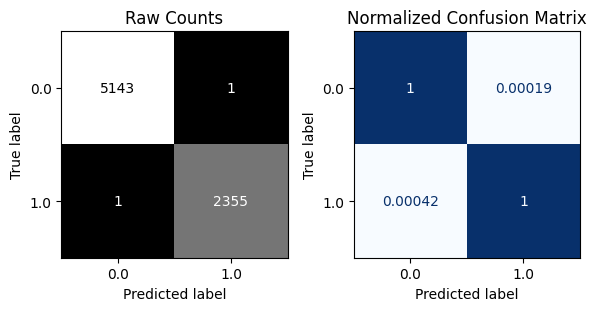


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1723
         1.0       0.76      0.68      0.72       777

    accuracy                           0.83      2500
   macro avg       0.81      0.79      0.80      2500
weighted avg       0.83      0.83      0.83      2500



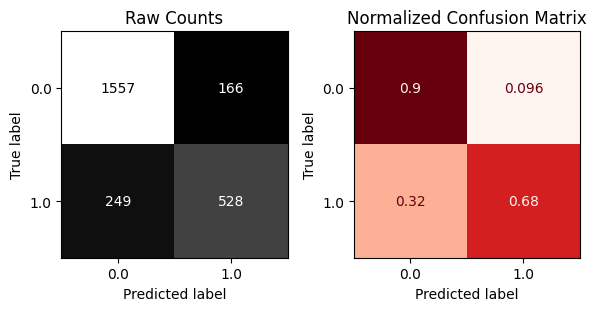

In [ ]:
#evaluate RF model
evaluate_classification(RandomF_defult_pipe, X_train, y_train, X_test, y_test)

##Extract and visualize the top 10 features using permutation importance

In [ ]:
feature_names = RandomF_defult_pipe[0].get_feature_names_out()
importances = pd.Series(RandomF_defult_pipe[-1].feature_importances_, index= feature_names)

importances.sort_values(ascending=False)

,0
CREDIT_SCORE,0.165457
DRIVING_EXPERIENCE,0.125774
ANNUAL_MILEAGE,0.096865
VEHICLE_OWNERSHIP,0.082635
AGE,0.070721
INCOME,0.064595
SPEEDING_VIOLATIONS,0.061628
PAST_ACCIDENTS,0.059725
POSTAL_CODE,0.055394
EDUCATION,0.034964


In [ ]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax





<Axes: title={'center': 'Top 10 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

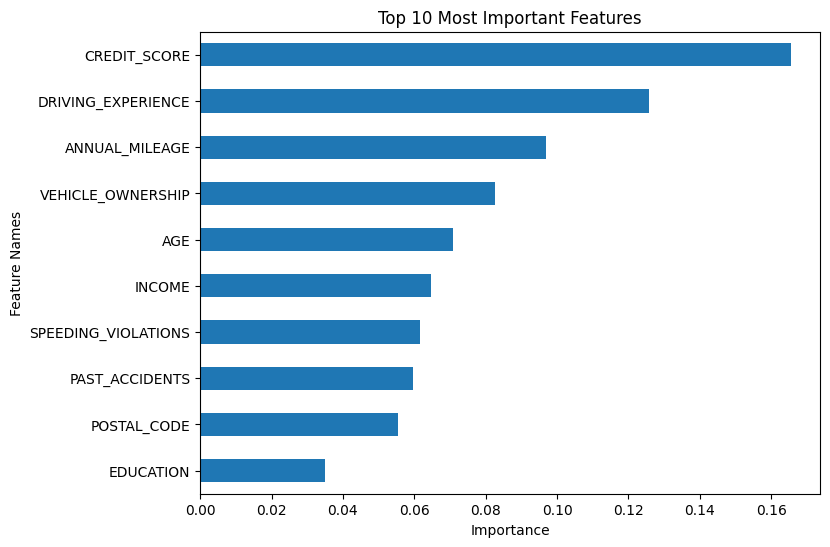

In [ ]:
plot_importance(importances, top_n = 10)


##Add your observations: Do these features make sense based on the business case?
- we notice from the above plot that features **CREDIT_SCORE** is the most important one and this makes sense because credit behavior often correlates with risk behavior — careful financial habits often reflect careful driving habits.

- the second imortant feature is **DRIVING_EXPERIENCE** as driving experience directly impacts accident risk

- **ANNUAL_MILEAGE** is the third factor and this makes sense as the more a car is driven, the greater the exposure to potential accidents.
- **VEHICLE_OWNERSHIP** Ownership type can reflect driver responsibility and vehicle condition.

##Create Explanatory Visualizations for the most important features.
- Select 2 out of the top 10 features from your permutation importances and produce explanatory visualizations showing the relationship between the feature and the target.
The purpose is to demonstrate key trends you found that will be of interest to a stakeholder.

In [ ]:
"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='rating',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y='rating',
                           figsize=(6,4),
                           ):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','linewidth':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

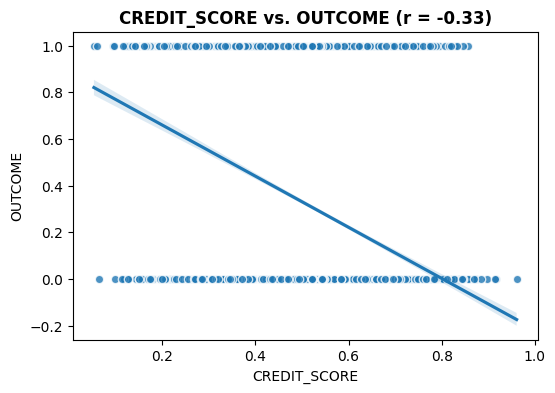

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'CREDIT_SCORE vs. OUTCOME (r = -0.33)'}, xlabel='CREDIT_SCORE', ylabel='OUTCOME'>)

In [ ]:
feature= 'CREDIT_SCORE'
plot_numeric_vs_target(df, feature, 'OUTCOME')


- Credit Score is
a measure of a customer’s financial reliability — higher credit scores indicate more responsible financial behavior.
he plot shows the relationship between CREDIT_SCORE (x-axis) and OUTCOME (y-axis), where the correlation coefficient is −0.33.

- There is a moderate negative correlation between credit score and the outcome.

- As CREDIT_SCORE increases, the probability of a positive OUTCOME (e.g., a claim or default) tends to decrease.

- In simpler terms, drivers with lower credit scores are more likely to have a claim (or negative insurance outcome), while those with higher credit scores tend to have fewer.
Why it makes sense:

Studies show that people with higher credit scores tend to file fewer or less severe insurance claims.

This is because credit behavior often correlates with risk behavior — careful financial habits often reflect careful driving habits.

Many insurers legally use credit-based insurance scores as a risk factor (where regulations allow).

✅ Conclusion:
Yes — credit score is a strong and logical predictor of claim likelihood and risk level.

/tmp/ipython-input-2770400525.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DRIVING_EXPERIENCE', y='OUTCOME', data=df, estimator='mean', palette='viridis')


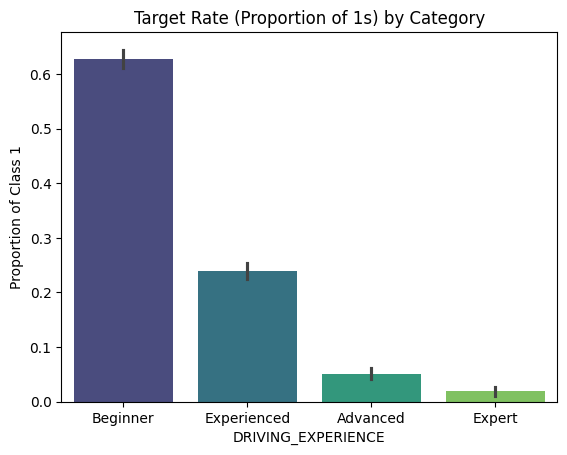

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='DRIVING_EXPERIENCE', y='OUTCOME', data=df, estimator='mean', palette='viridis')
plt.title('Target Rate (Proportion of 1s) by Category')
plt.ylabel('Proportion of Class 1')
plt.show()


- Beginners have the highest proportion of class 1 (around 0.63).

- The rate drops sharply for Experienced drivers (~0.25), and continues to decrease for Advanced and Expert drivers (both below 0.1).

- The overall trend is strongly decreasing — as driving experience increases, the likelihood of a class 1 outcome decreases.
💡 Business Insight

- This pattern makes perfect sense from an insurance risk perspective:

- Less experienced drivers are more prone to accidents or claims due to limited driving skills and risk awareness.

- More experienced (advanced/expert) drivers tend to be safer, resulting in fewer claims.

✅ Summary:

The plot shows a clear negative relationship between driving experience and the likelihood of a claim. Beginners have the highest risk, while experienced and expert drivers show substantially lower claim rates. This aligns well with expected business logic in auto insurance risk modeling.